In [41]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

In [42]:
# Create Spark session
spark = SparkSession.builder \
    .appName("Alzheimer's Disease Analysis") \
    .getOrCreate()

# Load the CSV file into a Spark DataFrame
file_path = "Resources/alzheimers_disease_data.csv"
alzheimers_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the schema of the DataFrame
alzheimers_df.printSchema()

# Display the first few rows of the DataFrame
alzheimers_df.show(5)

root
 |-- PatientID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Ethnicity: integer (nullable = true)
 |-- EducationLevel: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoking: integer (nullable = true)
 |-- AlcoholConsumption: double (nullable = true)
 |-- PhysicalActivity: double (nullable = true)
 |-- DietQuality: double (nullable = true)
 |-- SleepQuality: double (nullable = true)
 |-- FamilyHistoryAlzheimers: integer (nullable = true)
 |-- CardiovascularDisease: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Depression: integer (nullable = true)
 |-- HeadInjury: integer (nullable = true)
 |-- Hypertension: integer (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- CholesterolTotal: double (nullable = true)
 |-- CholesterolLDL: double (nullable = true)
 |-- CholesterolHDL: double (nullable = true)
 |-- CholesterolTrig

In [43]:
# Separate target variable and features
features = alzheimers_df.columns
features.remove('PatientID')
features.remove('Diagnosis')
features.remove('DoctorInCharge')

# StringIndexer for the target variable
indexer = StringIndexer(inputCol="Diagnosis", outputCol="label")

# VectorAssembler for the feature variables
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Create a pipeline to transform the data
pipeline = Pipeline(stages=[indexer, assembler])

# Fit and transform the data
transformed_data = pipeline.fit(alzheimers_df).transform(alzheimers_df)

# Split the data into training and testing sets
train_data, test_data = transformed_data.randomSplit([0.8, 0.2], seed=5)

# Convert Spark DataFrame to Pandas DataFrame for sklearn
train_data_pd = train_data.toPandas()
test_data_pd = test_data.toPandas()

# Separate features and labels
X_train = train_data_pd[features]
y_train = train_data_pd['label']
X_test = test_data_pd[features]
y_test = test_data_pd['label']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [44]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=500, random_state=5)
rf_model.fit(X_train_scaled, y_train)

# Make predictions with Random Forest
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest AUC:", auc_rf)
print("Random Forest Confusion Matrix:\n", conf_matrix_rf)
print("Random Forest Classification Report:\n", class_report_rf)


Random Forest Accuracy: 0.9543269230769231
Random Forest AUC: 0.9639892578125
Random Forest Confusion Matrix:
 [[283   5]
 [ 14 114]]
Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       288
         1.0       0.96      0.89      0.92       128

    accuracy                           0.95       416
   macro avg       0.96      0.94      0.95       416
weighted avg       0.95      0.95      0.95       416



In [ ]:
# Feature importance for Random Forest
rf_feature_importance = rf_best.feature_importances_
rf_importance_df = pd.DataFrame(list(zip(features, rf_feature_importance)), columns=["Feature", "Importance"])
rf_importance_df = rf_importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance for Random Forest using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df)
plt.title('Feature Importance in Random Forest Model')
plt.show()


In [45]:
# Initialize and train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=5)
dt_model.fit(X_train_scaled, y_train)

# Make predictions with Decision Tree
y_pred_dt = dt_model.predict(X_test_scaled)
y_prob_dt = dt_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate Decision Tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_prob_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt)

print("Decision Tree Accuracy:", accuracy_dt)
print("Decision Tree AUC:", auc_dt)
print("Decision Tree Confusion Matrix:\n", conf_matrix_dt)
print("Decision Tree Classification Report:\n", class_report_dt)

Decision Tree Accuracy: 0.9086538461538461
Decision Tree AUC: 0.892795138888889
Decision Tree Confusion Matrix:
 [[269  19]
 [ 19 109]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       288
         1.0       0.85      0.85      0.85       128

    accuracy                           0.91       416
   macro avg       0.89      0.89      0.89       416
weighted avg       0.91      0.91      0.91       416



In [ ]:
# Feature importance for Decision Tree
dt_feature_importance = dt_best.feature_importances_
dt_importance_df = pd.DataFrame(list(zip(features, dt_feature_importance)), columns=["Feature", "Importance"])
dt_importance_df = dt_importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance for Decision Tree using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=dt_importance_df)
plt.title('Feature Importance in Decision Tree Model')
plt.show()

In [46]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(random_state=5)
lr_model.fit(X_train_scaled, y_train)

# Make predictions with Logistic Regression
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate Logistic Regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
class_report_lr = classification_report(y_test, y_pred_lr)

print("Logistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression AUC:", auc_lr)
print("Logistic Regression Confusion Matrix:\n", conf_matrix_lr)
print("Logistic Regression Classification Report:\n", class_report_lr)

Logistic Regression Accuracy: 0.84375
Logistic Regression AUC: 0.8974609375
Logistic Regression Confusion Matrix:
 [[260  28]
 [ 37  91]]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       288
         1.0       0.76      0.71      0.74       128

    accuracy                           0.84       416
   macro avg       0.82      0.81      0.81       416
weighted avg       0.84      0.84      0.84       416



In [47]:
# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=5)
gb_model.fit(X_train_scaled, y_train)

# Make predictions with Gradient Boosting
y_pred_gb = gb_model.predict(X_test_scaled)
y_prob_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate Gradient Boosting model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
auc_gb = roc_auc_score(y_test, y_prob_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
class_report_gb = classification_report(y_test, y_pred_gb)

print("Gradient Boosting Accuracy:", accuracy_gb)
print("Gradient Boosting AUC:", auc_gb)
print("Gradient Boosting Confusion Matrix:\n", conf_matrix_gb)
print("Gradient Boosting Classification Report:\n", class_report_gb)

Gradient Boosting Accuracy: 0.9471153846153846
Gradient Boosting AUC: 0.9620225694444444
Gradient Boosting Confusion Matrix:
 [[280   8]
 [ 14 114]]
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       288
         1.0       0.93      0.89      0.91       128

    accuracy                           0.95       416
   macro avg       0.94      0.93      0.94       416
weighted avg       0.95      0.95      0.95       416



### ROC (Receiver Operating Characteristic) Curve and AUC (Area Under the Curve)
The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier as its discrimination threshold is varied. The Area Under the Curve (AUC) measures the entire two-dimensional area underneath the entire ROC curve.

c:\Users\jacob\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\jacob\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\jacob\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\jacob\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\jacob\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na 

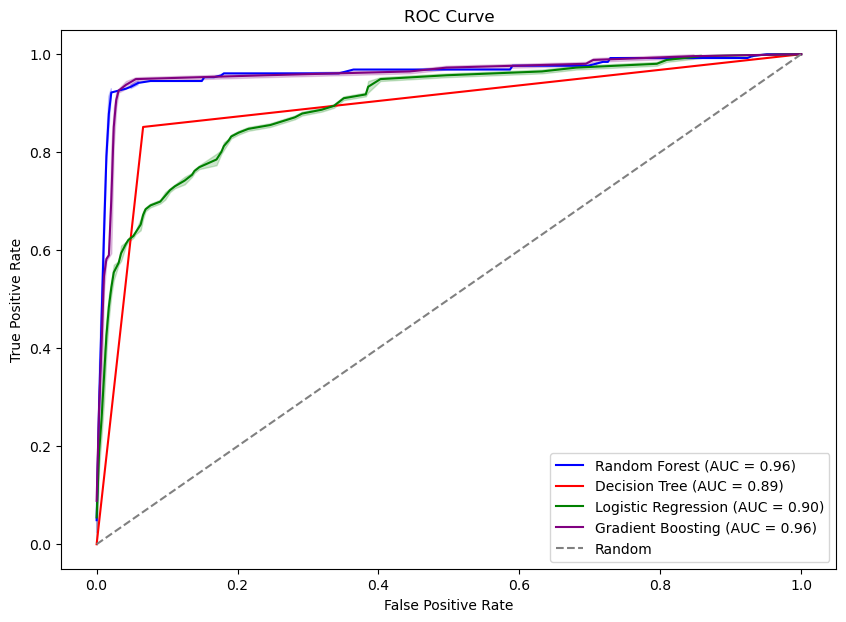

Random Forest AUC: 0.9639892578125
Decision Tree AUC: 0.892795138888889
Logistic Regression AUC: 0.8974609375
Gradient Boosting AUC: 0.9620225694444444


In [48]:
# Compute ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

# Compute ROC curve and AUC for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)

# Compute ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)

# Compute ROC curve and AUC for Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)

# Plot ROC curves using Seaborn
plt.figure(figsize=(10, 7))

sns.lineplot(x=fpr_rf, y=tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='blue')
sns.lineplot(x=fpr_dt, y=tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})', color='red')
sns.lineplot(x=fpr_lr, y=tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})', color='green')
sns.lineplot(x=fpr_gb, y=tpr_gb, label=f'Gradient Boosting (AUC = {auc_gb:.2f})', color='purple')
sns.lineplot(x=[0, 1], y=[0, 1], label='Random', color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print("Random Forest AUC:", auc_rf)
print("Decision Tree AUC:", auc_dt)
print("Logistic Regression AUC:", auc_lr)
print("Gradient Boosting AUC:", auc_gb)


In [50]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=5), param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the Random Forest model
grid_search_rf.fit(X_train_scaled, y_train)

# Get the best parameters and the corresponding performance
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Best parameters for Random Forest: ", best_params_rf)
print("Best cross-validation accuracy for Random Forest: ", best_score_rf)

# Refit the model with the best parameters
rf_best = RandomForestClassifier(**best_params_rf, random_state=5)
rf_best.fit(X_train_scaled, y_train)

# Make predictions with the optimized Random Forest model
y_pred_rf_best = rf_best.predict(X_test_scaled)
accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)
conf_matrix_rf_best = confusion_matrix(y_test, y_pred_rf_best)
class_report_rf_best = classification_report(y_test, y_pred_rf_best)

print("Optimized Random Forest Accuracy:", accuracy_rf_best)
print("Optimized Random Forest Confusion Matrix:\n", conf_matrix_rf_best)
print("Optimized Random Forest Classification Report:\n", class_report_rf_best)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy for Random Forest:  0.9318452133064584
Optimized Random Forest Accuracy: 0.9519230769230769
Optimized Random Forest Confusion Matrix:
 [[283   5]
 [ 15 113]]
Optimized Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       288
         1.0       0.96      0.88      0.92       128

    accuracy                           0.95       416
   macro avg       0.95      0.93      0.94       416
weighted avg       0.95      0.95      0.95       416



In [51]:
# Hyperparameter tuning for Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=5), param_grid=param_grid_dt, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the Decision Tree model
grid_search_dt.fit(X_train_scaled, y_train)

# Get the best parameters and the corresponding performance
best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

print("Best parameters for Decision Tree: ", best_params_dt)
print("Best cross-validation accuracy for Decision Tree: ", best_score_dt)

# Refit the model with the best parameters
dt_best = DecisionTreeClassifier(**best_params_dt, random_state=5)
dt_best.fit(X_train_scaled, y_train)

# Make predictions with the optimized Decision Tree model
y_pred_dt_best = dt_best.predict(X_test_scaled)
accuracy_dt_best = accuracy_score(y_test, y_pred_dt_best)
conf_matrix_dt_best = confusion_matrix(y_test, y_pred_dt_best)
class_report_dt_best = classification_report(y_test, y_pred_dt_best)

print("Optimized Decision Tree Accuracy:", accuracy_dt_best)
print("Optimized Decision Tree Confusion Matrix:\n", conf_matrix_dt_best)
print("Optimized Decision Tree Classification Report:\n", class_report_dt_best)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Decision Tree:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best cross-validation accuracy for Decision Tree:  0.9197514617447652
Optimized Decision Tree Accuracy: 0.9447115384615384
Optimized Decision Tree Confusion Matrix:
 [[280   8]
 [ 15 113]]
Optimized Decision Tree Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       288
         1.0       0.93      0.88      0.91       128

    accuracy                           0.94       416
   macro avg       0.94      0.93      0.93       416
weighted avg       0.94      0.94      0.94       416



In [53]:
# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize GridSearchCV for Gradient Boosting
grid_search_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state=5), param_grid=param_grid_gb, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the Gradient Boosting model
grid_search_gb.fit(X_train_scaled, y_train)

# Get the best parameters and the corresponding performance
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

print("Best parameters for Gradient Boosting: ", best_params_gb)
print("Best cross-validation accuracy for Gradient Boosting: ", best_score_gb)

# Refit the model with the best parameters
gb_best = GradientBoostingClassifier(**best_params_gb, random_state=5)
gb_best.fit(X_train_scaled, y_train)

# Make predictions with the optimized Gradient Boosting model
y_pred_gb_best = gb_best.predict(X_test_scaled)
accuracy_gb_best = accuracy_score(y_test, y_pred_gb_best)
conf_matrix_gb_best = confusion_matrix(y_test, y_pred_gb_best)
class_report_gb_best = classification_report(y_test, y_pred_gb_best)

print("Optimized Gradient Boosting Accuracy:", accuracy_gb_best)
print("Optimized Gradient Boosting Confusion Matrix:\n", conf_matrix_gb_best)
print("Optimized Gradient Boosting Classification Report:\n", class_report_gb_best)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for Gradient Boosting:  {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation accuracy for Gradient Boosting:  0.9474254968266396
Optimized Gradient Boosting Accuracy: 0.9543269230769231
Optimized Gradient Boosting Confusion Matrix:
 [[282   6]
 [ 13 115]]
Optimized Gradient Boosting Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       288
         1.0       0.95      0.90      0.92       128

    accuracy                           0.95       416
   macro avg       0.95      0.94      0.95       416
weighted avg       0.95      0.95      0.95       416



In [54]:
import csv

# Save results to a CSV file
with open('Resources/model_optimization_log.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Model", "Parameters", "Accuracy"])
    for i, (params, mean_score) in enumerate(zip(grid_search_rf.cv_results_['params'], grid_search_rf.cv_results_['mean_test_score'])):
        writer.writerow([i + 1, "Random Forest", params, mean_score])
    for i, (params, mean_score) in enumerate(zip(grid_search_dt.cv_results_['params'], grid_search_dt.cv_results_['mean_test_score'])):
        writer.writerow([i + 1, "Decision Tree", params, mean_score])
    for i, (params, mean_score) in enumerate(zip(grid_search_gb.cv_results_['params'], grid_search_gb.cv_results_['mean_test_score'])):
        writer.writerow([i + 1, "Gradient Boosting", params, mean_score])